In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm
from itertools import product

## Load Data

In [19]:
columns =['Subject', 'Noise Color', 'Trial', 'Noise Trial', 'Session', 'Coherence', 'Correct Response', 'Reaction Time']
data = pd.read_csv('allData.txt', header = None, names=columns)
data['Subject'] = [sub.split('_')[2][-6:] for sub in data['Subject']]
data = data.loc[(data['Noise Color']=='white') | (data['Noise Color']=='pink') | (data['Noise Color']=='blue')]
SubjectList = np.unique(data['Subject'])
print(SubjectList)

['LAB001' 'LAB002' 'LAB004' 'LAB006' 'LAB008' 'LAB011' 'LAB014']


## Plot Reaction Times and Coherence Differences over Trials
### White Noise - LAB001

Text(0.5, 1.0, 'Single Subject Reaction Times and Coherence Difference over Trials')

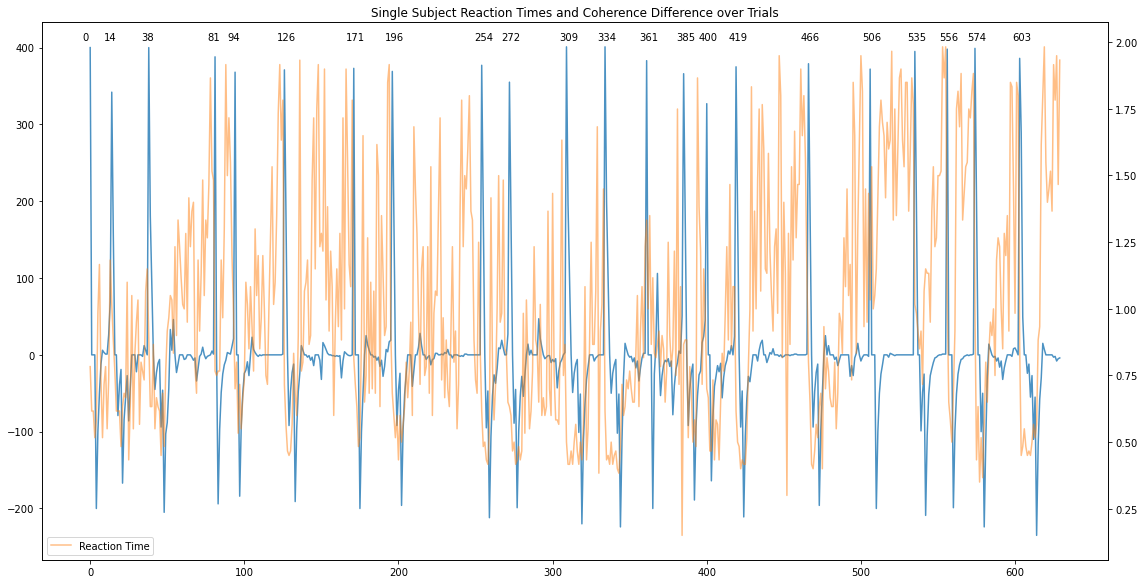

In [42]:
white = data[(data['Noise Color'] == 'white') & (data['Subject']=='LAB001') & (data['Correct Response']==1)]
rt = white['Reaction Time'].to_numpy()
trials = np.arange(len(rt))

diff_coh = np.diff(white['Coherence'], prepend=0)
reset = diff_coh>=200
reset_trials = trials[reset]
min_reset_inter = 10
false_reset = [n+1 for n, reset_diff in enumerate(np.diff(reset_trials)) if reset_diff <= min_reset_inter]
reset_trials = np.delete(reset_trials, false_reset)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(diff_coh, alpha=0.8)
for trial in reset_trials:
    ax.text(s=str(trial), x=trial-5, y=410)
# Plot Reaction Times
ax2 = ax.twinx() 
ax2.plot(trials, rt, color='tab:orange', alpha=0.5, label = 'Reaction Time')
ax2.legend(loc='lower left')
fig.tight_layout()
ax.set_title('Single Subject Reaction Times and Coherence Difference over Trials')

## Test Threshold Detection
Set WindowSize and Perf_Acc to vary the criteria of the Threshold

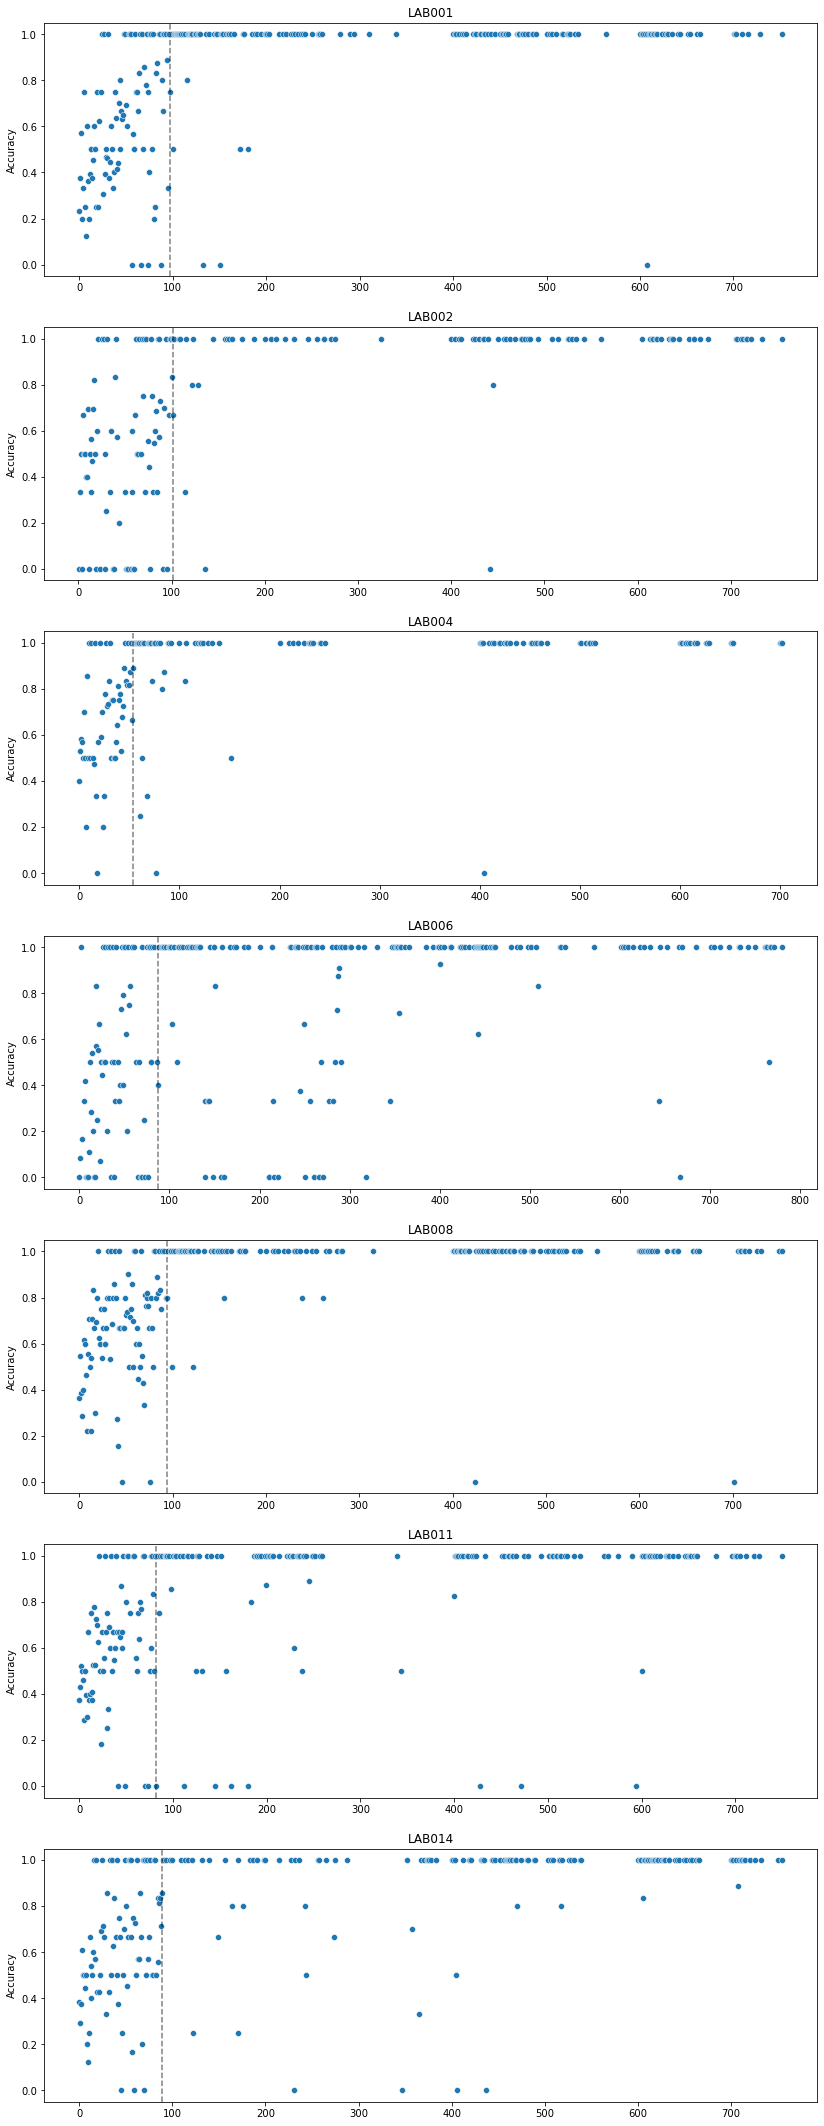

In [33]:
windowsize = 6
perf_acc = 5

fig, ax = plt.subplots(7,1, figsize=(12,30))
fig.tight_layout(pad=3.0)
for n, sub in enumerate(np.unique(data['Subject'])):
    white = data[(data['Noise Color'] == 'white') & (data['Subject']==sub)]
    # Get Accuracy Dataframe
    acc_df = {'Coherence':[], 'Accuracy':[]}
    for c in np.unique(white['Coherence']): 
        acc = np.mean(white.loc[white['Coherence']==c, 'Correct Response'])
        acc_df['Coherence'].append(c)
        acc_df['Accuracy'].append(acc)
    acc_df = pd.DataFrame(acc_df)

    # Get Coherency Threshold 
    perf_idx = np.arange(len(acc_df))[acc_df['Accuracy']==1]
    for idx in perf_idx:
        window = acc_df.iloc[idx:idx+windowsize, 1]
        if np.sum(window==1)>=perf_acc:
            thresh_idx = idx-1
            thresh = acc_df.iloc[thresh_idx,0]
            break
    sns.scatterplot(data=acc_df, x='Coherence', y='Accuracy', ax=ax[n])
    ax[n].axvline(x=thresh, ymin=0, ymax=1, linestyle='dashed', color='k', alpha=0.5)
    ax[n].set_xlabel('')
    ax[n].set_title(sub)

In [5]:
colors = ['white', 'blue', 'pink']
subs = np.unique(data['Subject'])
res = {'Subject':[], 'Noise Color': [], 'Coherence Thresh': []}

for noise_color, sub in product(colors,subs):
    df = data[(data['Noise Color'] == noise_color) & (data['Subject']==sub) & (data['Correct Response']==1)]
    if len(df)==0:
        continue
    rt = df['Reaction Time'].to_numpy()
    trials = np.arange(len(rt))

    diff_coh = np.diff(df['Coherence'], prepend=0)
    reset = diff_coh>=200
    reset_trials = trials[reset]
    min_reset_inter = 10
    false_reset = [n+1 for n, reset_diff in enumerate(np.diff(reset_trials)) if reset_diff <= min_reset_inter]
    reset_trials = np.delete(reset_trials, false_reset)

    window_size = 10
    analyze_trials = [np.arange(trial-window_size, trial) for trial in reset_trials[1:]]
    analyze_trials = [val for window in analyze_trials for val in window]
    analyze_windows = np.zeros(len(trials))
    analyze_windows[analyze_trials] = 1.

    thresh_coherence = df.iloc[analyze_trials,5]
    res['Subject'].append(sub); res['Noise Color'].append(noise_color)
    res['Coherence Thresh'].append(np.mean(thresh_coherence))

res_df = pd.DataFrame(res)

Text(0.5, 1.0, 'Coherence Thresholds')

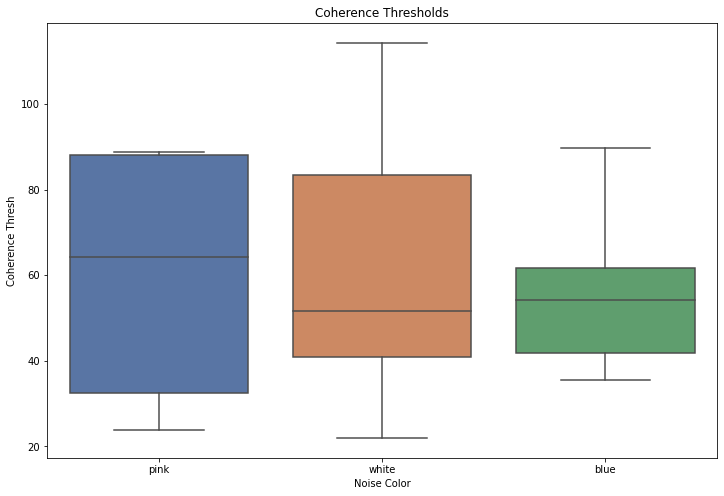

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=res_df, x='Noise Color', y='Coherence Thresh', 
            order=['pink', 'white', 'blue'], ax=ax, palette='deep')
ax.set_title('Coherence Thresholds')

## Plot Reaction Time vs. Coherence 
## White Noise

Text(0.5, 1.0, 'Reaction Time vs. Motion Coherence - White Noise')

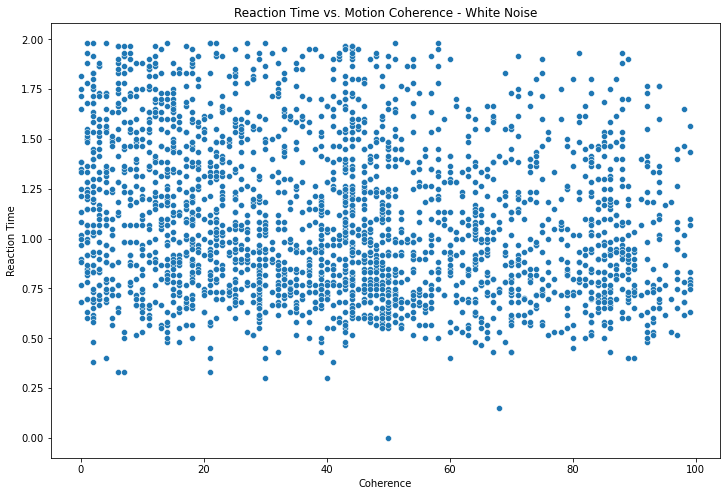

In [41]:
df = data[(data['Noise Color'] == 'white') & (data['Correct Response']==1)]
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df, x='Coherence', y='Reaction Time', ax=ax)
ax.set_title('Reaction Time vs. Motion Coherence - White Noise')

## Bined Coherence Values

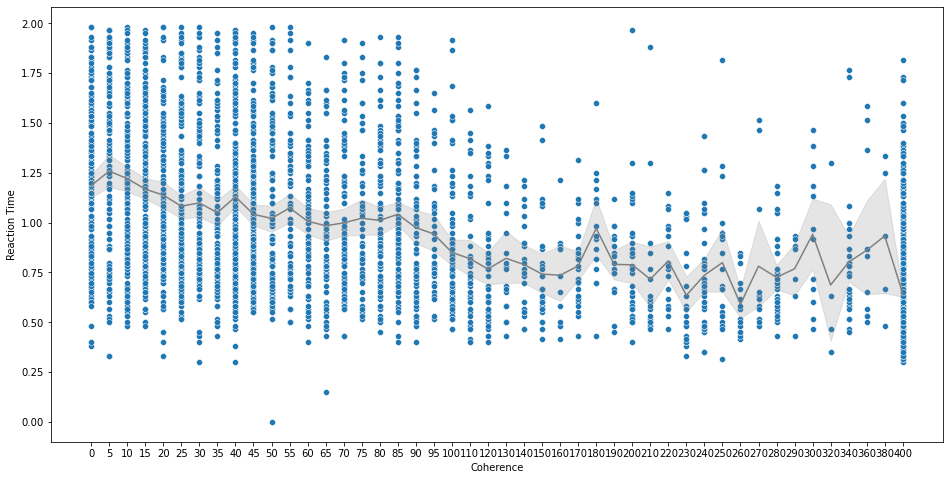

In [8]:
binsizes = [5,10,20]
bins = list(range(0,100,binsizes[0])) + list(range(100, 300, binsizes[1])) + list(range(300,401,binsizes[2])) 
bined_df = df.copy()
bined_df['Coherence'] = np.digitize(df['Coherence'], bins)


fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax)
sns.lineplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax, color='grey')
ax.set_xticks(list(range(1,len(bins)+1)))
ax.set_xticklabels([str(i) for i in bins]);

## Plot all Noise Colors

Text(0.5, 1.0, 'Reaction Time vs. Coherence Level over Noise Colors')

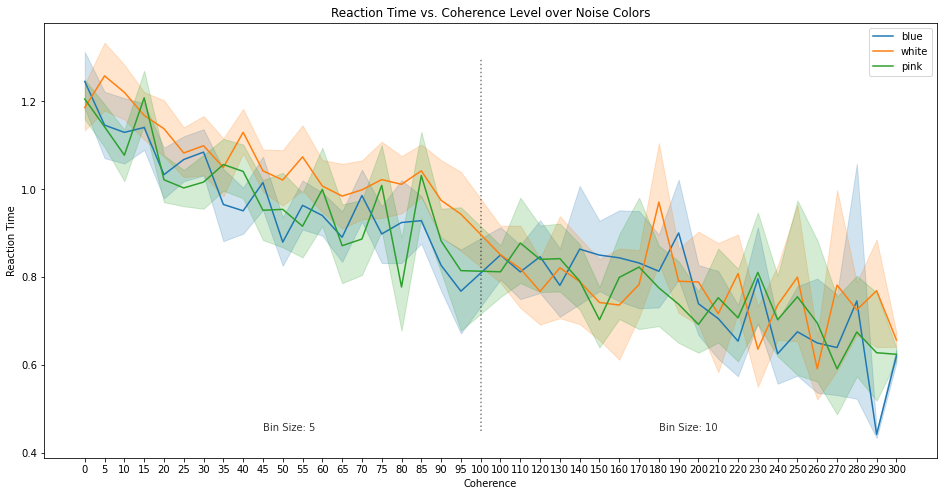

In [9]:
binsizes = [5,10]
bin_borders = [100,300]
bins = list(range(0,bin_borders[0]+1,binsizes[0])) + list(range(bin_borders[0], bin_borders[1]+1, binsizes[1]))
# Set up plot
fig, ax = plt.subplots(figsize=(16,8))
ax.set_xticks(list(range(1,len(bins)+1)))
ax.set_xticklabels([str(i) for i in bins]);

for color in ['blue','white','pink']:
    df = data[(data['Noise Color'] == color) & (data['Correct Response']==1)]
    bined_df = df.copy()
    bined_df['Coherence'] = np.digitize(df['Coherence'], bins)
    sns.lineplot(data=bined_df, x='Coherence', y='Reaction Time', ax=ax, label=color)

ax.vlines(105/5, 0.45, 1.3, 'k', 'dotted', alpha=0.5)
ax.text(x=10, y = 0.45, s='Bin Size: 5', alpha=0.8)
ax.text(x=30, y = 0.45, s='Bin Size: 10', alpha=0.8)
ax.set_title('Reaction Time vs. Coherence Level over Noise Colors')

In [33]:
idx = (data['Noise Color'] == 'blue') & (data['Coherence'] == 0) &  (data['Correct Response'] ==1)
data.iloc[np.arange(len(data))[idx]]


,Subject,Noise Color,Trial,Noise Trial,Session,Coherence,Correct Response,Reaction Time
3871,LAB006,blue,897,150,4,0,1,0.59983
3872,LAB006,blue,898,151,4,0,1,0.69974
3873,LAB006,blue,899,152,4,0,1,0.91638
30904,LAB011,blue,248,20,2,0,1,1.31622
30905,LAB011,blue,249,21,2,0,1,1.59946
30906,LAB011,blue,250,22,2,0,1,1.84939
30907,LAB011,blue,251,23,2,0,1,1.13295
30910,LAB011,blue,254,26,2,0,1,1.19962
30911,LAB011,blue,255,27,2,0,1,1.83270
30915,LAB011,blue,259,31,2,0,1,1.39952
